In [13]:
from datetime import datetime
import itertools
import json

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)


run_folder = "../results/3_mo_cross_val/"
network_folder = "kcm/"
fold_num = 0
device = torch.device("cpu")
torch.set_default_device("cpu")

In [10]:
print("="*30)
print(f"RUN MODEL: '{run_folder}'")
print(f"NETWORK: '{network_folder}'")

### Set run and hyperparameters
EPOCHS = 50
BATCH_SIZE = 16
LEARN_RATE = 1e-3
HIDDEN_SIZE = 32

### Load train/test data
print("="*30)
data_folder = run_folder + network_folder + "deeptte_formatted/"
print(f"Loading data from '{data_folder}'...")
# Load config
with open(data_folder + "config.json", "r") as f:
    config = json.load(f)
# Load GTFS-RT samples
train_data_chunks, valid_data = data_utils.load_train_test_data(data_folder, config['n_folds'])
# Load GTFS data
print(f"Loading and merging GTFS files from '{config['gtfs_folder']}'...")
gtfs_data = data_utils.merge_gtfs_files("."+config['gtfs_folder'])

### Run full training process for each validation fold
run_results = []

RUN MODEL: '../results/3_mo_cross_val/'
NETWORK: 'kcm/'
Loading data from '../results/3_mo_cross_val/kcm/deeptte_formatted/'...
Loading and merging GTFS files from './data/kcm_gtfs/2020_09_23/'...


In [14]:
print("="*30)
print(f"FOLD: {fold_num}")
test_data = train_data_chunks[fold_num]
train_data = [x for i,x in enumerate(train_data_chunks) if i!=fold_num]
train_data = list(itertools.chain.from_iterable(train_data))

# Construct dataloaders for Pytorch models
train_dataset = data_loader.make_dataset(train_data, config, device)
test_dataset = data_loader.make_dataset(test_data, config, device)
valid_dataset = data_loader.make_dataset(valid_data, config, device)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
print(f"Successfully loaded {len(train_data)} training samples and {len(test_data)} testing samples.")

FOLD: 0
Successfully loaded 123759 training samples and 13752 testing samples.


In [15]:
### Train basic ff model
print("="*30)
print(f"Training basic ff network model...")
# Variables must be changed here, and in data_loader.
# Must change model file if using only continuous or only embedded variables
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24,
        'col': 8
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4,
        'col': 9
    },
    'driverID': {
        'vocab_size': config['n_unique_veh'],
        'embed_dims': 12,
        'col': 10
    }
}
ff_model = basic_ff.BasicFeedForward(
    train_dataloader.dataset[0][0].shape[0],
    embed_dict,
    HIDDEN_SIZE
).to(device)
ff_train_losses, ff_test_losses = ff_model.fit_to_data(train_dataloader, test_dataloader, LEARN_RATE, EPOCHS)
ff_model.eval()
ff_labels, ff_preds = ff_model.predict(valid_dataloader, config)

Training basic ff network model...
EPOCH: 0
LOSS: train 0.2700924858282324 valid 0.24238690733909607
EPOCH: 1
LOSS: train 0.22808735940025057 valid 0.22511732578277588
EPOCH: 2
LOSS: train 0.21882129145416526 valid 0.2053474634885788
EPOCH: 3
LOSS: train 0.21128634264561424 valid 0.19917570054531097
EPOCH: 4
LOSS: train 0.20707348223664854 valid 0.19061557948589325
EPOCH: 5
LOSS: train 0.20307928878445547 valid 0.19081354141235352
EPOCH: 6
LOSS: train 0.19993770044891773 valid 0.1878887414932251
EPOCH: 7
LOSS: train 0.19729159792214535 valid 0.1882079541683197
EPOCH: 8
LOSS: train 0.19665828911754957 valid 0.18370558321475983
EPOCH: 9
LOSS: train 0.1951026949968909 valid 0.18285632133483887
EPOCH: 10
LOSS: train 0.19418701318579676 valid 0.18331408500671387
EPOCH: 11
LOSS: train 0.1943407224403344 valid 0.18145091831684113
EPOCH: 12
LOSS: train 0.19152277226294329 valid 0.1810632348060608
EPOCH: 13
LOSS: train 0.190675011446968 valid 0.1834656000137329
EPOCH: 14
LOSS: train 0.192027378

<AxesSubplot: xlabel='Epoch', ylabel='value'>

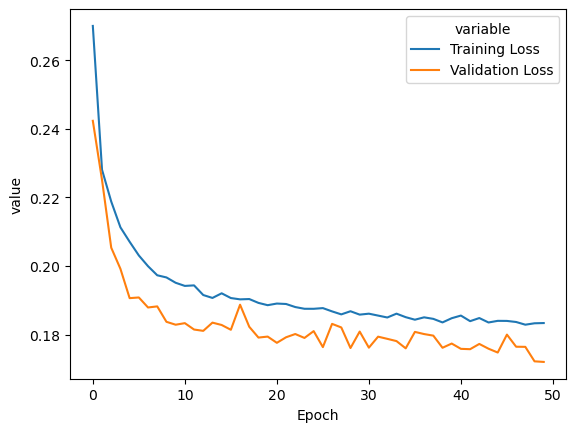

In [16]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(ff_train_losses))],
        "Training Loss": ff_train_losses,
        "Validation Loss": ff_test_losses
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))

In [17]:
# Look at predictions
print(f"MAPE: {metrics.mean_absolute_percentage_error(ff_labels, ff_preds)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(ff_labels, ff_preds))}")
print(f"MAE: {metrics.mean_absolute_error(ff_labels, ff_preds)}")

MAPE: 0.18565595149993896
RMSE: 400.4659729003906
MAE: 261.9237976074219
